# Mask R-CNN Demo
A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
print('hello world')

hello world


In [2]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import cv2 as cv

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

#%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

D:\anaconda\envs\maskrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda\envs\maskrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda\envs\maskrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda\envs\maskrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: P

## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [3]:

class ShapesConfig(coco.Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 10  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 800
    #IMAGE_MAX_DIM = 1024
    IMAGE_MAX_DIM = 2048

    # Use smaller anchors because our image and objects are small
    #RPN_ANCHOR_SCALES = (8 * 6, 16 * 6, 32 * 6, 64 * 6, 128 * 6)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE =100

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 50

class InferenceConfig(coco.CocoConfig):
#class InferenceConfig(ShapesConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

#实例化一个对象，用于配置展示
#类继承关系，Config->CocoConfig->Inferenceconfig
config = InferenceConfig()
config.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [4]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [29]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']
class_names2=['person','bicycle','car','motorcycle','airplane','bus','train','truck','boat','bird','cat','dog','horse','sheep','cow','elephant','bear','zebra','giraffe']

## Run Object Detection

Processing 1 images
image                    shape: (375, 1242, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1242.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
4


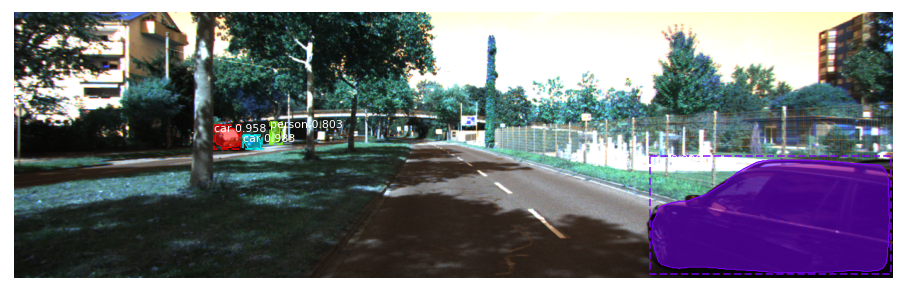

In [30]:
# Load a random image from the images folder
#file_names = next(os.walk(IMAGE_DIR))[2]
file_image = "D:\maskrcnn\Mask_RCNN\images\8512296263_5fc5458e20_z.jpg"
file_image2 = r"D:\maskrcnn\Mask_RCNN\1.jpg"
file_image3 = r"D:\maskrcnn\Mask_RCNN\000000.png"
file_image4 = r"D:\Data_KITTI\left\training\image_02\0003\000000.png"
#image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

image = skimage.io.imread(file_image)
image2 = cv.imread(file_image2,cv.IMREAD_COLOR)
image3 = cv.imread(file_image3,cv.IMREAD_COLOR)
image4 = cv.imread(file_image4,cv.IMREAD_COLOR)

#cv.imshow("原图",image2)
#cv.waitKey(0)
# Run detection
results = model.detect([image4], verbose=1)


# Visualize results
r = results[0]
print(len(r['class_ids']))
visualize.display_instances(image4, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [59]:
print(r['masks'].shape)

def trans_image(image, mask, object_class,i):
    height, width = image.shape[:2]
    modified_object=''
    if class_names2.count(object_class):
        #print(object_class)
        modified_object=object_class
    for row in range(height):
        for col in range(width):
            if mask[row, col] == 1:
                #差一个 在class_name2中查找的语句
                image[row, col] = image[row, col]+i+1
    return image,modified_object


# height, width = image3.shape[:2]

# image_output = np.zeros((height, width))

# N_class = len(r['class_ids'])
# for i in range(N_class):
#     mask = r['masks'][:, :, i]
#     class_id = r['class_ids'][N_class-1]
#     image_output = trans_image(image_output, mask, class_id,i)
#     # image_output[:,:]=np.where(mask==1,image_output[:,:]+1+class_id,image_output[:,:])
#     # if mask.any()==1:
#     # print("mask")
# # print(image_output.shape)
# # image_output=trans_image(image_output)
# b=15000
# s='123'+str(b)+'.txt'
# np.savetxt(s, image_output, fmt="%d")
# print(image_output.shape)
# print(image_output)


(375, 1242, 4)


In [60]:
kitti_file=r"D:\Data_KITTI\left\training\image_02"
for count in range(20):
    image_file=kitti_file+"\\"+str(count).zfill(4)+"\\"
    for filename in os.listdir(image_file):
        #print(image_file)
        print(image_file+filename)

        image_ggml = cv.imread(image_file+filename, cv.IMREAD_COLOR)

        # cv.imshow("image",image_ggml)
        # cv.waitKey(0)

        results_ggml = model.detect([image_ggml], verbose=1)
        
        r_ggml = results_ggml[0]

        height, width = image_ggml.shape[:2]

        image_output_ggml = np.zeros((height, width))
        image_output_ggml[:,:]=-1
        Modified_object_class=[]
        N_class = len(r_ggml['class_ids'])
        #print(N_class)
        #print(r_ggml['class_ids'])
        for i in range(N_class):
            mask = r_ggml['masks'][:, :, i]
            class_id = r_ggml['class_ids'][i]
            object_class=class_names[class_id]
            #print(object_class)
            image_output_ggml,Modified_object = trans_image(image_output_ggml, mask,object_class,i)
            #print(i)
            if Modified_object is not '':
                Modified_object_class.append(Modified_object)
        print(Modified_object_class)
        s_tmp=kitti_file+"\\"+"semantics"+"\\"

        semantic_file=s_tmp+str(count).zfill(4)+"mask"

        if not os.path.exists(semantic_file):
            os.makedirs(semantic_file)
            
        semantic_txt=semantic_file+"\\"+filename+".mask"

        np.savetxt(semantic_txt, image_output_ggml , fmt="%d")
        with open(semantic_txt,'r+') as txt_output:
            old_txt=txt_output.read()
            txt_output.seek(0)
            N_class=len(Modified_object_class)
            txt_output.write("375 1242 %s\n"%str(N_class))
            for i in range(N_class):
                object_class_name=Modified_object_class[i]
                txt_output.write(object_class_name+'\n')
            txt_output.write(old_txt)


D:\Data_KITTI\left\training\image_02\0000\000000.png
Processing 1 images
image                    shape: (375, 1242, 3)        min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1242.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
['person', 'person', 'bicycle', 'bicycle', 'car', 'bicycle', 'bicycle', 'person']
D:\Data_KITTI\left\training\image_02\0000\000001.png
Processing 1 images
image                    shape: (375, 1242, 3)        min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1242.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
['person

In [61]:
kitti_file=r"D:\Data_KITTI\left\training\image_02"
for count in range(20):
    image_file=kitti_file+"\\"+str(count).zfill(4)+"\\"
    for filename in os.listdir(image_file):
        print(image_file)
        print(image_file+filename)

        image_ggml = cv.imread(image_file+filename, cv.IMREAD_COLOR)

        # cv.imshow("image",image_ggml)
        # cv.waitKey(0)

        results_ggml = model.detect([image_ggml], verbose=1)
        
        r_ggml = results_ggml[0]

        height, width = image_ggml.shape[:2]

        image_output_ggml = np.zeros((height, width))

        N_class = len(r_ggml['class_ids'])
        #print(N_class)
        for i in range(N_class):
            mask = r_ggml['masks'][:, :, i]
            class_id = r_ggml['class_ids'][N_class-1]
            image_output_ggml = trans_image(image_output_ggml, mask, class_id, i)
            #print(i)

        s_tmp=kitti_file+"\\"+"semantics"+"\\"

        semantic_file=s_tmp+str(count).zfill(4)+"semantic"

        if not os.path.exists(semantic_file):
            os.makedirs(semantic_file)
            
        semantic_txt=semantic_file+"\\"+filename.replace(".png","")+".txt"

        np.savetxt(semantic_txt, image_output_ggml , fmt="%d")




D:\Data_KITTI\left\training\image_02\0000\
D:\Data_KITTI\left\training\image_02\0000\000000.png
Processing 1 images
image                    shape: (375, 1242, 3)        min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1242.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


AttributeError: 'tuple' object has no attribute 'shape'